In [8]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt


def apply_rule(df, rule_str):
    """
    Apply a decision rule string to filter a dataframe.
    Handles common rule patterns automatically.
    """
    import re
    
    # Replace 'and' with '&' and 'or' with '|'
    rule_str = rule_str.replace(" and ", " & ")
    rule_str = rule_str.replace(" or ", " | ")
    
    # Handle IN operator - convert "col IN {'a', 'b'}" to "col in ['a', 'b']"
    rule_str = re.sub(r'\s*IN\s*\{([^}]+)\}', r' in [\1]', rule_str)
    
    # Replace single = with == (but not <=, >=, !=)
    rule_str = re.sub(r'(?<![<>!])=(?!=)', '==', rule_str)
    
    # Replace all column names with backticks for pandas query
    for col in df.columns:
        # Use word boundaries to match exact column names
        rule_str = re.sub(r'\b' + re.escape(col) + r'\b', f'`{col}`', rule_str)
    
    # print(f"Transformed rule: {rule_str}")
    
    # Evaluate the rule using pandas query
    try:
        result = df.query(rule_str)
        # print("result shape",result.shape)
        return result
    except Exception as e:
        print(f"Error applying rule: {e}")
        return pd.DataFrame()





def rule_statistics(ruled_df, selected_features):
    stats = {}
    for feature in selected_features:
        stats[feature] = {
            'mean': ruled_df[feature].mean(),
            'std': ruled_df[feature].std(),
            'var': ruled_df[feature].var(),
            'min': ruled_df[feature].min(),
            'max': ruled_df[feature].max(),
            'count': ruled_df[feature].count(),
            'coeff_var': ruled_df[feature].std() / ruled_df[feature].mean() if ruled_df[feature].mean() != 0 else None,
            
            
        }
    return pd.DataFrame(stats)

def compare_stats(rule_stats, cluster_stats,selected_features):
    mean_diff = np.mean([abs(rule_stats[f]['mean'] - cluster_stats[f]['mean']) / cluster_stats[f]['mean'] 
                         for f in selected_features if cluster_stats[f]['mean'] != 0])
    var_ratio = np.mean([rule_stats[f]['var'] / cluster_stats[f]['var'] 
                        for f in selected_features if cluster_stats[f]['var'] != 0])
    cv_ratio = np.mean([rule_stats[f]['coeff_var'] / cluster_stats[f]['coeff_var'] 
                       for f in selected_features if cluster_stats[f]['coeff_var'] is not None and cluster_stats[f]['coeff_var'] != 0])
    return mean_diff * 100, var_ratio, cv_ratio





insights_path = './data/workflows/clusters_comprehensive_insights.json'
workflows_path = './data/workflows/workflows_clustered.csv'
rules_path = './data/workflows/cluster_decision_rules.csv'
with open(insights_path, 'r') as f:
    insights = json.load(f)
workflows_df = pd.read_csv(workflows_path)
workflows_df= workflows_df.rename(columns={'fairness method': 'fairness_method', 'max depth': 'max_depth', 'n estimators': 'n_estimators', 'model type': 'model_type', 'random state': 'random_state'})

rules = pd.read_csv(rules_path)
n_cluster=workflows_df["cluster"].unique()
n_cluster.sort()




Cluster 0


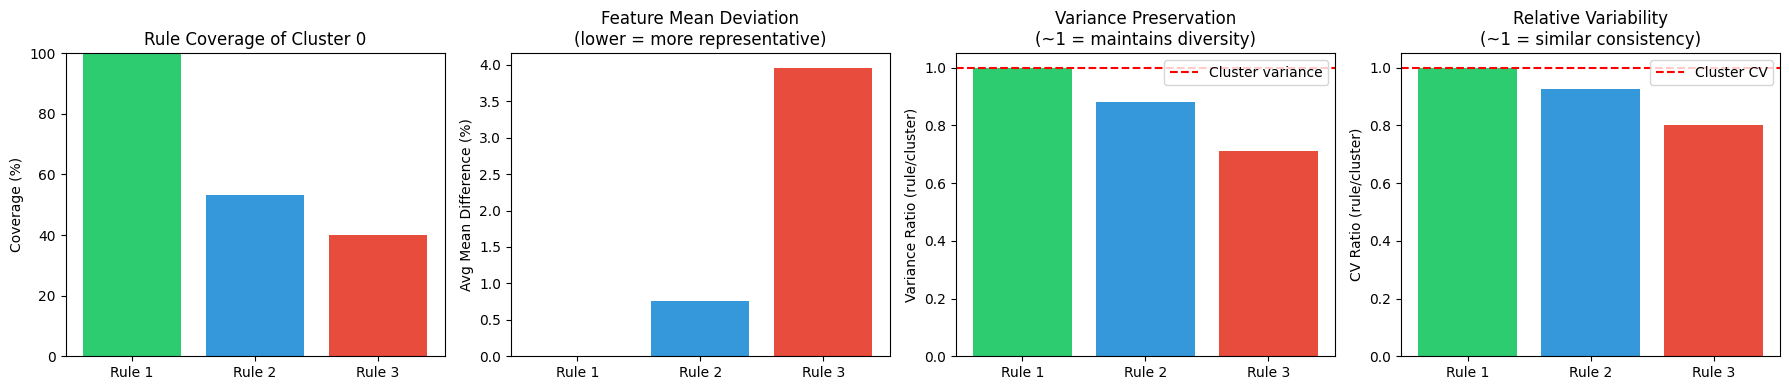


=== RULE VALIDATION SUMMARY ===
(Based on 8 most important features)

Rule 1:
  → Good - maintains cluster diversity

Rule 2:
  → Good - maintains cluster diversity

Rule 3:
  → Good - maintains cluster diversity
Cluster 1


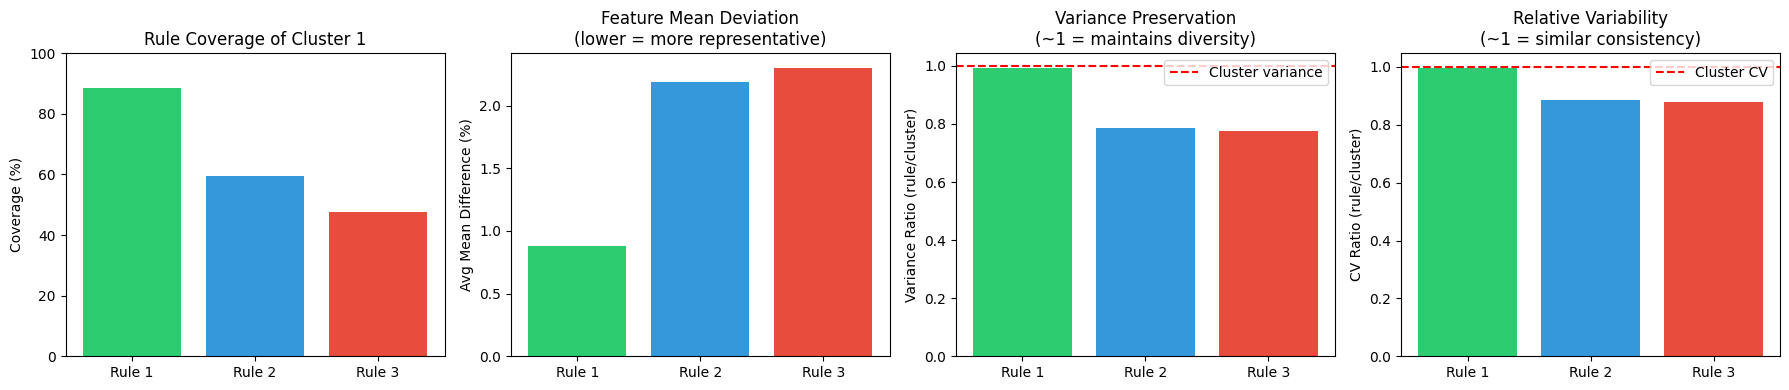


=== RULE VALIDATION SUMMARY ===
(Based on 7 most important features)

Rule 1:
  → Good - maintains cluster diversity

Rule 2:
  → Good - maintains cluster diversity

Rule 3:
  → Good - maintains cluster diversity
Cluster 2


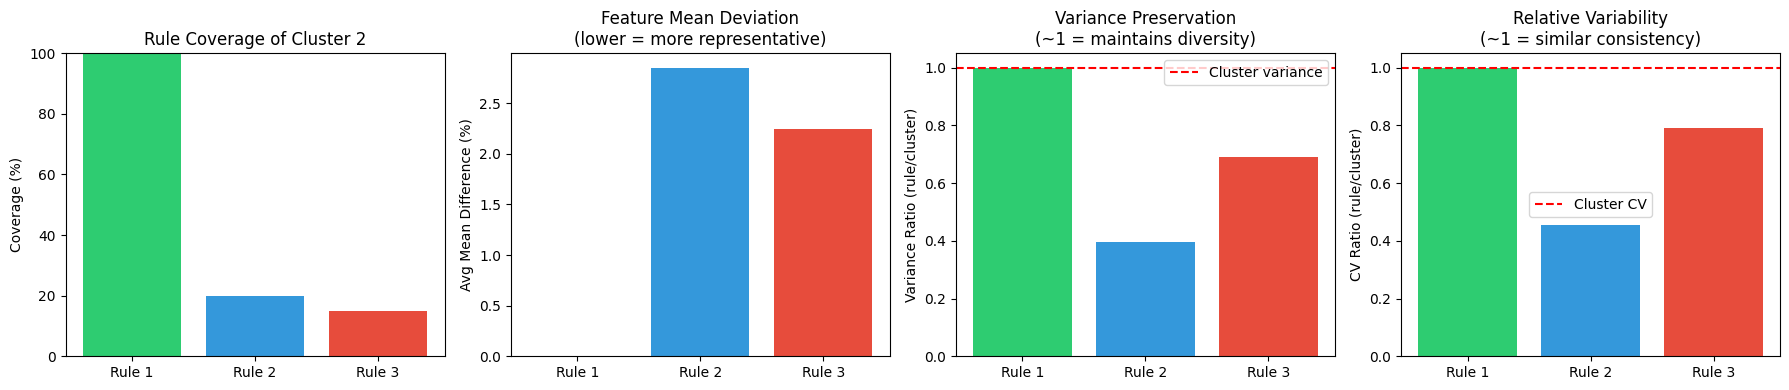


=== RULE VALIDATION SUMMARY ===
(Based on 8 most important features)

Rule 1:
  → Good - maintains cluster diversity

Rule 2:
  → Too specific - captures homogeneous subset

Rule 3:
  → Good - maintains cluster diversity
Cluster 3


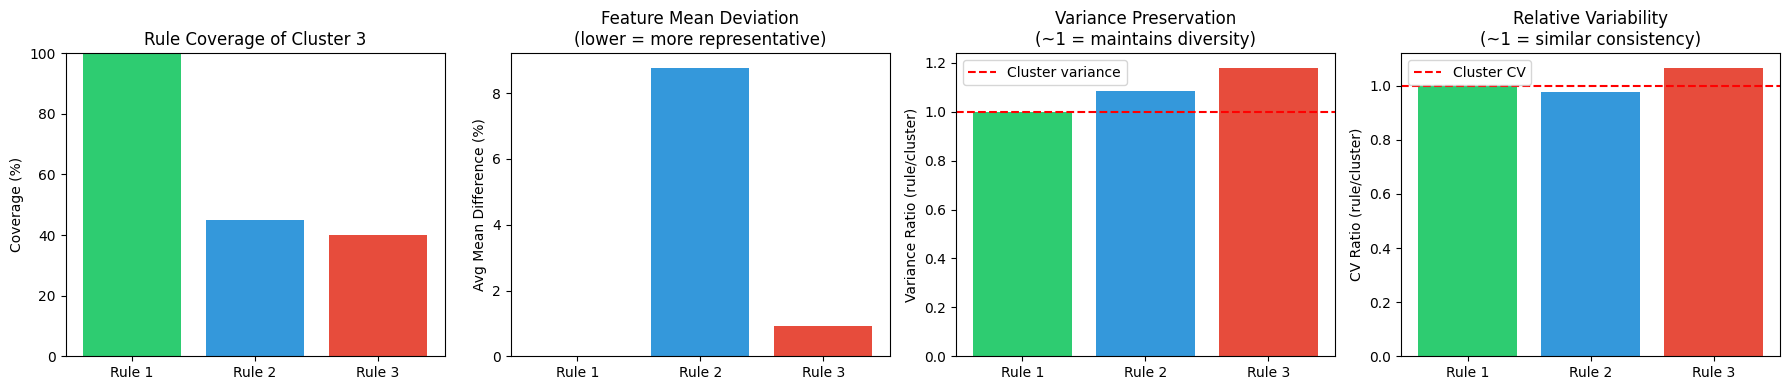


=== RULE VALIDATION SUMMARY ===
(Based on 9 most important features)

Rule 1:
  → Good - maintains cluster diversity

Rule 2:
  → Good - maintains cluster diversity

Rule 3:
  → Good - maintains cluster diversity
Cluster 4


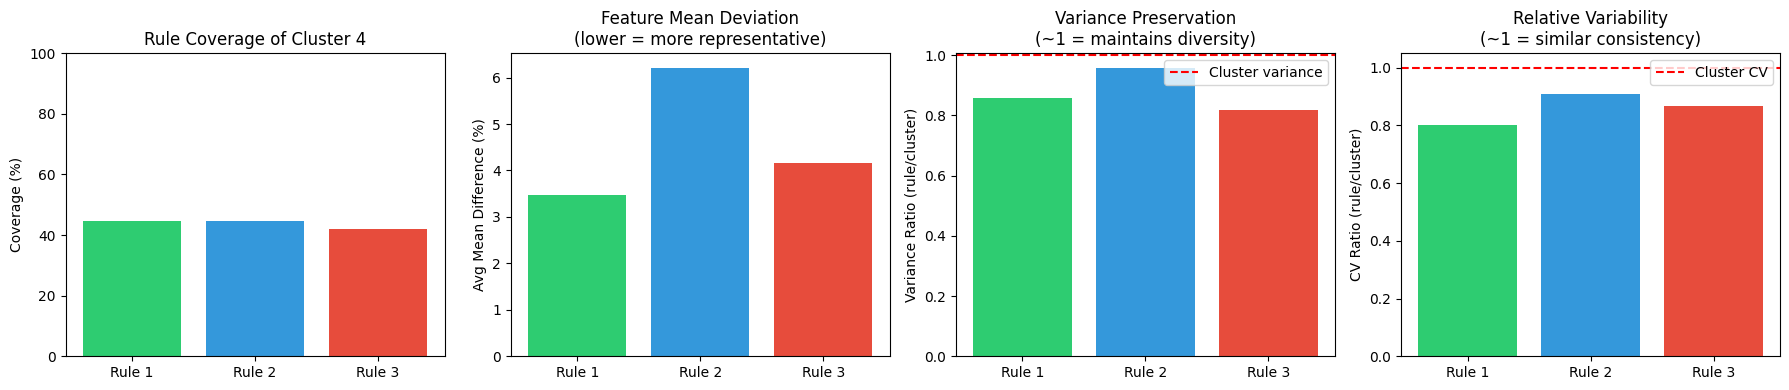


=== RULE VALIDATION SUMMARY ===
(Based on 8 most important features)

Rule 1:
  → Good - maintains cluster diversity

Rule 2:
  → Good - maintains cluster diversity

Rule 3:
  → Good - maintains cluster diversity
Cluster 5


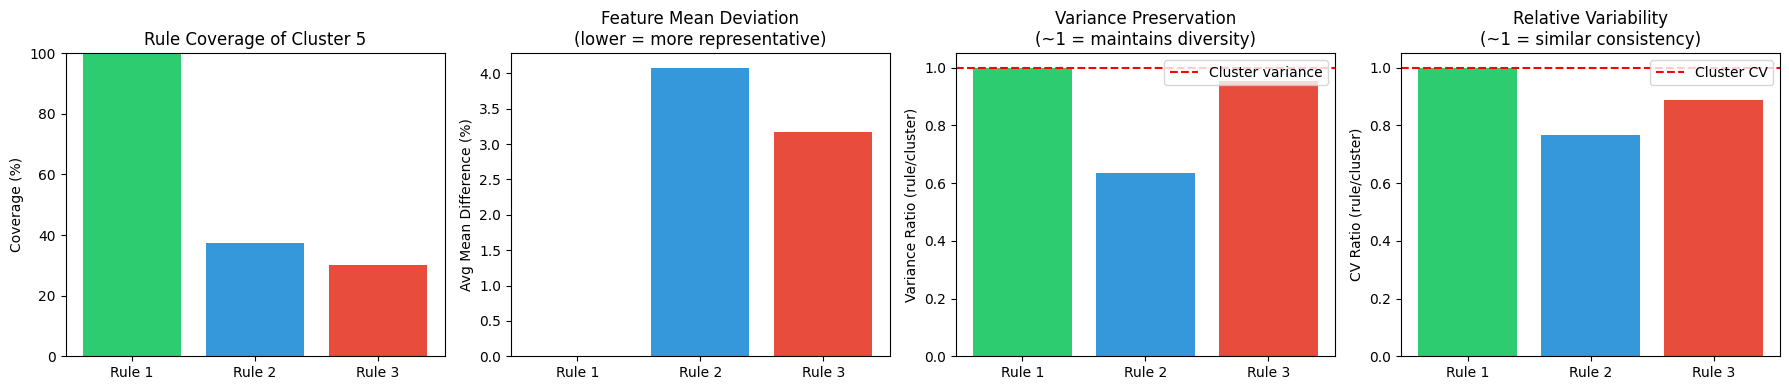


=== RULE VALIDATION SUMMARY ===
(Based on 9 most important features)

Rule 1:
  → Good - maintains cluster diversity

Rule 2:
  → Good - maintains cluster diversity

Rule 3:
  → Good - maintains cluster diversity
Cluster 6


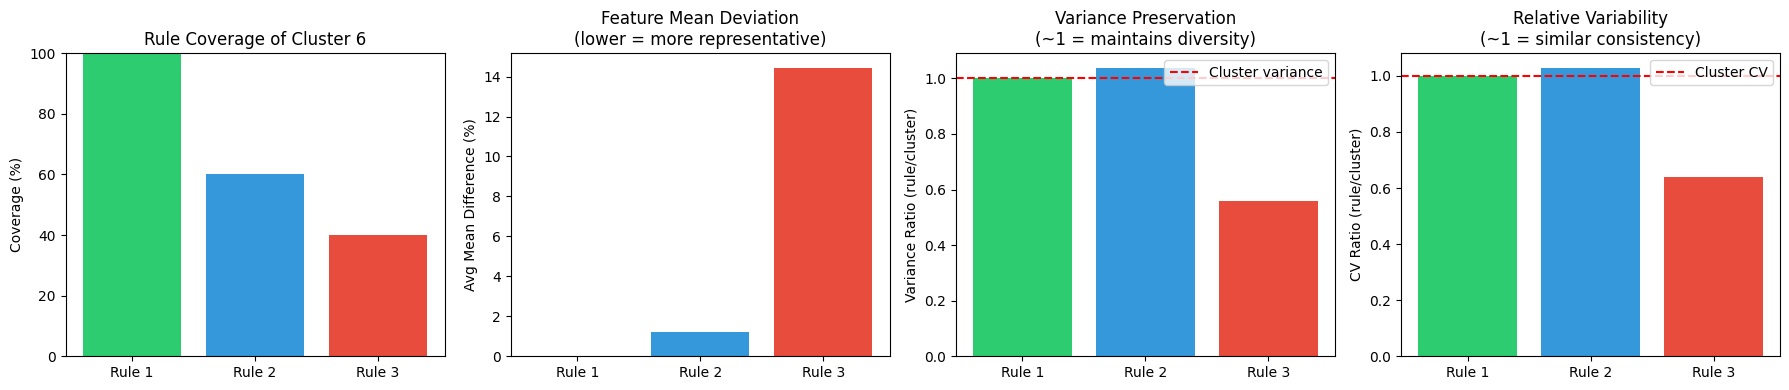


=== RULE VALIDATION SUMMARY ===
(Based on 8 most important features)

Rule 1:
  → Good - maintains cluster diversity

Rule 2:
  → Good - maintains cluster diversity

Rule 3:
  → Good - maintains cluster diversity


In [9]:

for c in n_cluster:

    print("Cluster",c)



    cluster0=workflows_df[workflows_df['cluster']==c]
    # print("cluster0",cluster0.head())

    insights_0=insights[str(c)]
    rules_0=rules[rules['cluster_id']==c]
    selected_features=insights_0["feature_selection"]["selected_features"]
    feature_statistics=insights_0["feature_selection"]["feature_statistics"]

    ruled_1=apply_rule(cluster0, rules_0["rule"][rules_0["rule_number"]==1].values[0])
    ruled_2=apply_rule(cluster0, rules_0["rule"][rules_0["rule_number"]==2].values[0])
    ruled_3=apply_rule(cluster0, rules_0["rule"][rules_0["rule_number"]==3].values[0])





    rule_statistics1 = rule_statistics(ruled_1, selected_features)
    rule_statistics2 = rule_statistics(ruled_2, selected_features)
    rule_statistics3 = rule_statistics(ruled_3, selected_features)
    cluster0_statistics = rule_statistics(cluster0, selected_features)



    # print(f"Selected features for validation: {selected_features}\n")

    # Calculate coverage for each rule
    cluster_size = len(cluster0)
    coverages = {
        'Rule 1': len(ruled_1) / cluster_size * 100,
        'Rule 2': len(ruled_2) / cluster_size * 100,
        'Rule 3': len(ruled_3) / cluster_size * 100
    }

    # Calculate mean difference, variance ratio, and CV ratio for each rule


    mean_diff_1, var_ratio_1, cv_ratio_1 = compare_stats(rule_statistics1, cluster0_statistics,selected_features)
    mean_diff_2, var_ratio_2, cv_ratio_2 = compare_stats(rule_statistics2, cluster0_statistics,selected_features)
    mean_diff_3, var_ratio_3, cv_ratio_3 = compare_stats(rule_statistics3, cluster0_statistics,selected_features)

    # Simple validation plot
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    # Coverage
    axes[0].bar(['Rule 1', 'Rule 2', 'Rule 3'], list(coverages.values()), color=['#2ecc71', '#3498db', '#e74c3c'])
    axes[0].set_ylabel('Coverage (%)')
    axes[0].set_title(f'Rule Coverage of Cluster {c}')
    axes[0].set_ylim(0, 100)

    # Mean difference (lower is better - more representative)
    axes[1].bar(['Rule 1', 'Rule 2', 'Rule 3'], [mean_diff_1, mean_diff_2, mean_diff_3], color=['#2ecc71', '#3498db', '#e74c3c'])
    axes[1].set_ylabel('Avg Mean Difference (%)')
    axes[1].set_title('Feature Mean Deviation\n(lower = more representative)')

    # Variance ratio (close to 1 is better)
    axes[2].bar(['Rule 1', 'Rule 2', 'Rule 3'], [var_ratio_1, var_ratio_2, var_ratio_3], color=['#2ecc71', '#3498db', '#e74c3c'])
    axes[2].axhline(y=1, color='red', linestyle='--', label='Cluster variance')
    axes[2].set_ylabel('Variance Ratio (rule/cluster)')
    axes[2].set_title('Variance Preservation\n(~1 = maintains diversity)')
    axes[2].legend()

    # CV ratio (close to 1 is better)
    axes[3].bar(['Rule 1', 'Rule 2', 'Rule 3'], [cv_ratio_1, cv_ratio_2, cv_ratio_3], color=['#2ecc71', '#3498db', '#e74c3c'])
    axes[3].axhline(y=1, color='red', linestyle='--', label='Cluster CV')
    axes[3].set_ylabel('CV Ratio (rule/cluster)')
    axes[3].set_title('Relative Variability\n(~1 = similar consistency)')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n=== RULE VALIDATION SUMMARY ===")
    print(f"(Based on {len(selected_features)} most important features)")
    for i, (r_stats, rule_name) in enumerate([(rule_statistics1, 'Rule 1'), 
                                                (rule_statistics2, 'Rule 2'), 
                                                (rule_statistics3, 'Rule 3')], 1):
        cov = list(coverages.values())[i-1]
        mean_d, var_r, cv_r = [(mean_diff_1, var_ratio_1, cv_ratio_1), (mean_diff_2, var_ratio_2, cv_ratio_2), (mean_diff_3, var_ratio_3, cv_ratio_3)][i-1]
        
        print(f"\n{rule_name}:")
        # print(f"  Coverage: {cov:.1f}% ({len([ruled_1, ruled_2, ruled_3][i-1])}/{cluster_size} samples)")
        # print(f"  Mean deviation: {mean_d:.1f}%")
        # print(f"  Variance ratio: {var_r:.2f}")
        # print(f"  CV ratio: {cv_r:.2f}")
        
        # Simple verdict
        if var_r < 0.5:
            verdict = "Too specific - captures homogeneous subset"
        elif var_r > 1.5:
            verdict = "Too broad - may include outliers"
        else:
            verdict = "Good - maintains cluster diversity"
        
        print(f"  → {verdict}")
    
   
    
